#Deep Learning with CUDA Lab Report 05


In this lab report, I want to focus on Generative Adversial Networks (GAN).

GAN is composed of two neural networks:
*  **Generator** which generates new data instances of data with goal to generate data indistinguishible from the real data.
* **Discriminator** which evaluates generated data against real data.



In this report I will explore the performance implications of various GAN configurations:
*  **Optimizers and learning rates** We explore how asymmetric learning rates (different settings for the Generator and Discriminator) influence the training dynamics and performance.  
*   **Model Volumne:** What are the consequences of increasing the model size on the GAN's ability to learn and generalize?
*   **Latent space:** How the size of latent space impacts the results?

To streamline the learning process - all models in all iterations were trained using batch_size = 128, and for 15 epochs each.




###Imports


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import datetime
import os, sys

from matplotlib.pyplot import imshow, imsave
from IPython.display import Image, display
import matplotlib.pyplot as plt

%matplotlib inline

#Models

##GAN v1 - Vanilla Model

In [ ]:
MODEL_v1_NAME = 'vanilla-GAN'
MODEL_v2_NAME = 'vanilla-GANv2'
MODEL_v3_NAME = 'vanilla-GANv3'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [ ]:
def get_sample_image(G, n_noise):
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

##GAN v2 - Denser Models


In [ ]:
class DiscriminatorV2(nn.Module):
    def __init__(self, input_size=784, num_classes=1):
        super(DiscriminatorV2, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.Linear(256,256), ## Added Layer
            nn.LeakyReLU(0.2),  ## Added Layer
            nn.Linear(256,256),## Added Layer
            nn.LeakyReLU(0.2), ## Added Layer
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [ ]:
class GeneratorV2(nn.Module):
    def __init__(self, input_size=100, num_classes=784):
        super(GeneratorV2, self).__init__()
        self.layer = nn.Sequential(


            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),


            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),


            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),


            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),

            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),

            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),

            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()

)

    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

## GAN v3 - Network With One Convolutional Layer

In [ ]:
class DiscriminatorV3(nn.Module):
    def __init__(self, input_size=784, num_classes=1):
        super(DiscriminatorV3, self).__init__()
        self.init_size = 28

        # First part processes the image as a 2D input
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, stride=2, padding=1),  # Reduce dimension
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Reduce dimension
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten()
        )

        # Linear layers follow after convolution
        self.linear_layers = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv_layer(x)
        y_ = self.linear_layers(x)
        return y_

In [ ]:


class GeneratorV3(nn.Module):
    def __init__(self, input_size=150, num_classes=784):
        super(GeneratorV3, self).__init__()
        self.init_size = 4
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512)
        )

        self.layer2 = nn.Sequential(
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512 * self.init_size * self.init_size)
        )

        self.conv_layer = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(256 * self.init_size * self.init_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)

        # Reshape for convolution
        x = x.view(x.size(0), 512, self.init_size, self.init_size)  # Reshape to (batch_size, channels, height, width)
        x = self.conv_layer(x)

        # Flatten for subsequent linear layers
        x = x.view(x.size(0), -1)
        y_ = self.layer3(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_



##MNIST, NOISE, BATCH SIZE, DATA LOADER, INITIALISATION

---



In [ ]:
n_noise = 100

In [ ]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [ ]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [ ]:
batch_size = 128
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

#Training Loop Function

In [ ]:
def train_gan(D, G, criterion, D_opt, G_opt, data_loader,  MODEL_NAME,MODEL_DIR, n_noise= 100, DEVICE = DEVICE, max_epoch =15 , n_critic = 1,save_interval=1000, log_interval=500):
    step = 0

    for epoch in range(max_epoch):
        for idx, (images, _) in enumerate(data_loader):
            # Training Discriminator
            real_images = images.to(DEVICE)
            real_labels = torch.ones(images.size(0), 1).to(DEVICE)
            fake_labels = torch.zeros(images.size(0), 1).to(DEVICE)

            # Real images
            D.zero_grad()
            outputs_real = D(real_images)
            D_loss_real = criterion(outputs_real, real_labels)

            # Fake images
            noise = torch.randn(images.size(0), n_noise).to(DEVICE)
            fake_images = G(noise)
            outputs_fake = D(fake_images.detach())
            D_loss_fake = criterion(outputs_fake, fake_labels)
            D_loss = D_loss_real + D_loss_fake

            D_loss.backward()
            D_opt.step()

            # Training Generator
            if step % n_critic == 0:
                G.zero_grad()
                outputs_fake = D(fake_images)
                G_loss = criterion(outputs_fake, real_labels)
                G_loss.backward()
                G_opt.step()

            # Logging
            if step % log_interval == 0:
                print(f'Epoch: {epoch}/{max_epoch}, Step: {step}, D Loss: {D_loss.item()}, G Loss: {G_loss.item()}')

            # Saving images
            if step % save_interval == 0:
                G.eval()
                img = get_sample_image(G, n_noise)
                imsave('{}/{}_GAN_step{}.jpg'.format(MODEL_DIR,MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
                G.train()



            step += 1

# Learning rate exploration

####Base model

In [ ]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

batch_size = 128
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)


criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

if not os.path.exists('samples_GAN_VANILLA'):
    os.makedirs('samples_GAN_VANILLA')

In [ ]:
train_gan(D, G, criterion, D_opt, G_opt, data_loader, MODEL_v1_NAME,'samples_GAN_VANILLA')

Epoch: 0/15, Step: 0, D Loss: 1.3749186992645264, G Loss: 0.7132970094680786
Epoch: 1/15, Step: 500, D Loss: 1.3020678758621216, G Loss: 1.4134184122085571
Epoch: 2/15, Step: 1000, D Loss: 1.376936674118042, G Loss: 0.9351815581321716
Epoch: 3/15, Step: 1500, D Loss: 1.2276915311813354, G Loss: 1.5005996227264404
Epoch: 4/15, Step: 2000, D Loss: 1.2404636144638062, G Loss: 0.8082701563835144
Epoch: 5/15, Step: 2500, D Loss: 1.1496187448501587, G Loss: 1.0577898025512695
Epoch: 6/15, Step: 3000, D Loss: 1.1857705116271973, G Loss: 0.8092178702354431
Epoch: 7/15, Step: 3500, D Loss: 1.153968095779419, G Loss: 0.8647459745407104
Epoch: 8/15, Step: 4000, D Loss: 1.2189204692840576, G Loss: 0.8311859369277954
Epoch: 9/15, Step: 4500, D Loss: 1.3306142091751099, G Loss: 0.6944766044616699
Epoch: 10/15, Step: 5000, D Loss: 1.3007665872573853, G Loss: 0.5820193886756897
Epoch: 11/15, Step: 5500, D Loss: 1.246779441833496, G Loss: 0.8884181976318359
Epoch: 12/15, Step: 6000, D Loss: 1.237543940

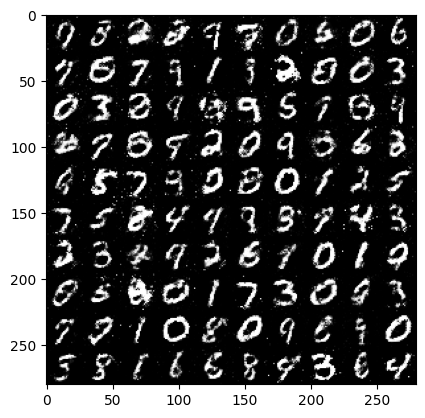

In [ ]:
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')


In [ ]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')

#### Base model - Generator with higeher learning rate

In [ ]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

if not os.path.exists('samples_GAN_GEN'):
    os.makedirs('samples_GAN_GEN')

In [ ]:
train_gan(D, G, criterion, D_opt, G_opt, data_loader, MODEL_v1_NAME,'samples_GAN_GEN')

Epoch: 0/15, Step: 0, D Loss: 1.3888176679611206, G Loss: 0.7176462411880493
Epoch: 1/15, Step: 500, D Loss: 1.3293064832687378, G Loss: 0.7512729167938232
Epoch: 2/15, Step: 1000, D Loss: 1.3739187717437744, G Loss: 0.6889525055885315
Epoch: 3/15, Step: 1500, D Loss: 1.3731606006622314, G Loss: 0.7848067283630371
Epoch: 4/15, Step: 2000, D Loss: 1.3451025485992432, G Loss: 0.9280139803886414
Epoch: 5/15, Step: 2500, D Loss: 1.2350125312805176, G Loss: 0.7455456256866455
Epoch: 6/15, Step: 3000, D Loss: 1.2791006565093994, G Loss: 0.8328088521957397
Epoch: 7/15, Step: 3500, D Loss: 1.2831666469573975, G Loss: 0.942658543586731
Epoch: 8/15, Step: 4000, D Loss: 1.2799917459487915, G Loss: 0.8398422002792358
Epoch: 9/15, Step: 4500, D Loss: 1.3358371257781982, G Loss: 0.7560825943946838
Epoch: 10/15, Step: 5000, D Loss: 1.3673553466796875, G Loss: 0.8007044792175293
Epoch: 11/15, Step: 5500, D Loss: 1.337939977645874, G Loss: 0.8091387152671814
Epoch: 12/15, Step: 6000, D Loss: 1.35109329

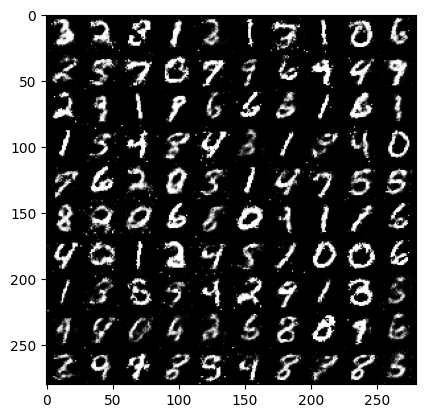

In [ ]:
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')


####Base model - Discriminator with higher learning rate

In [ ]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)



criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

if not os.path.exists('samples_GAN_DISC'):
    os.makedirs('samples_GAN_DISC')

In [ ]:
train_gan(D, G, criterion, D_opt, G_opt, data_loader, MODEL_v1_NAME,'samples_GAN_DISC')

Epoch: 0/15, Step: 0, D Loss: 1.421410322189331, G Loss: 0.7607467174530029
Epoch: 1/15, Step: 500, D Loss: 1.2037737369537354, G Loss: 0.8336188793182373
Epoch: 2/15, Step: 1000, D Loss: 1.3328742980957031, G Loss: 0.5987026691436768
Epoch: 3/15, Step: 1500, D Loss: 1.2092618942260742, G Loss: 1.0201317071914673
Epoch: 4/15, Step: 2000, D Loss: 1.3020881414413452, G Loss: 1.4287991523742676
Epoch: 5/15, Step: 2500, D Loss: 1.2185602188110352, G Loss: 0.8671950101852417
Epoch: 6/15, Step: 3000, D Loss: 1.1534886360168457, G Loss: 0.942059338092804
Epoch: 7/15, Step: 3500, D Loss: 1.268559217453003, G Loss: 1.1768354177474976
Epoch: 8/15, Step: 4000, D Loss: 1.1253514289855957, G Loss: 1.4742774963378906
Epoch: 9/15, Step: 4500, D Loss: 1.1934442520141602, G Loss: 0.9450151920318604
Epoch: 10/15, Step: 5000, D Loss: 1.173585057258606, G Loss: 1.6172339916229248
Epoch: 11/15, Step: 5500, D Loss: 1.1311476230621338, G Loss: 1.2789305448532104
Epoch: 12/15, Step: 6000, D Loss: 1.3631124496

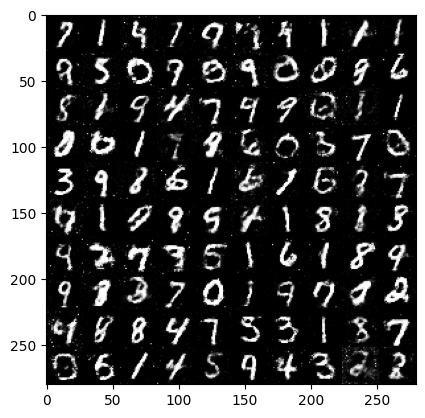

In [ ]:
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')


### Learning rate adjustments - conclusions

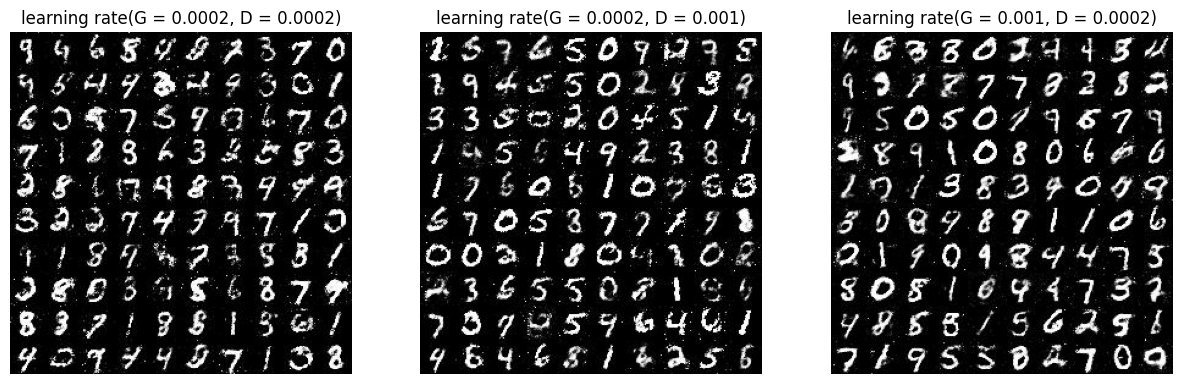

In [ ]:
# Image file paths
path1 = 'samples_GAN_VANILLA/vanilla-GAN_GAN_step7000.jpg'
path2 = 'samples_GAN_GEN/vanilla-GAN_GAN_step7000.jpg'
path3 = 'samples_GAN_DISC/vanilla-GAN_GAN_step7000.jpg'

# Load and display images side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize to scale the display size

axs[0].imshow(plt.imread(path1))
axs[0].set_title('learning rate(G = 0.0002, D = 0.0002)')
axs[0].axis('off')  # Turn off axis

axs[1].imshow(plt.imread(path2))
axs[1].set_title('learning rate(G = 0.0002, D = 0.001)')
axs[1].axis('off')  # Turn off axis

axs[2].imshow(plt.imread(path3))
axs[2].set_title('learning rate(G = 0.001, D = 0.0002)')
axs[2].axis('off')  # Turn off axis

plt.show()

In performed tests, that utilized different learning rates for the generator and discriminator didn't really help. GANs work best when neither side—the generator nor the discriminator—gets too strong too fast. They need to challenge each other equally to get good results.

We saw the clearest images when both parts used standard learning rates, and when the discriminator's rate was a bit higher than the generator's. This setup seems to make the discriminator push the generator harder, leading to more realistic images.

On the other hand, bumping up the generator's learning rate made things worse. The images got grainier and started to have more weird distortions or 'galaxies' as I call them. This happens because if the generator learns too fast, it doesn't get enough quality feedback from the discriminator, which can't keep up and fails to correct the generator's mistakes.

Given these outcomes, we've decided to stick with symmetric learning rates for both the generator and discriminator moving forward. This approach seems to offer the best balance and quality for our models.

# Experimenting with more complex network


##Base Case

We are going to use the same loss, optimizers and other parameters as in vanilla GANv1, let's see how the size of the network influences the quality of the outputs.



In [ ]:
D = DiscriminatorV2().to(DEVICE)
G = GeneratorV2(n_noise).to(DEVICE)


D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

if not os.path.exists('samples_GANv2'):
    os.makedirs('samples_GANv2')

In [ ]:
train_gan(D, G, criterion, D_opt, G_opt, data_loader, MODEL_v1_NAME,'samples_GANv2')

Epoch: 0/15, Step: 0, D Loss: 1.3715206384658813, G Loss: 0.7047022581100464
Epoch: 1/15, Step: 500, D Loss: 1.3191936016082764, G Loss: 0.7558917999267578
Epoch: 2/15, Step: 1000, D Loss: 1.3627533912658691, G Loss: 0.8043275475502014
Epoch: 3/15, Step: 1500, D Loss: 1.3602092266082764, G Loss: 1.011476755142212
Epoch: 4/15, Step: 2000, D Loss: 1.3848223686218262, G Loss: 1.1302821636199951
Epoch: 5/15, Step: 2500, D Loss: 1.310506820678711, G Loss: 0.9655303955078125
Epoch: 6/15, Step: 3000, D Loss: 1.376320719718933, G Loss: 0.782423198223114
Epoch: 7/15, Step: 3500, D Loss: 1.2550990581512451, G Loss: 0.9442079663276672
Epoch: 8/15, Step: 4000, D Loss: 1.2148265838623047, G Loss: 0.9631023406982422
Epoch: 9/15, Step: 4500, D Loss: 1.2110425233840942, G Loss: 0.9474214315414429
Epoch: 10/15, Step: 5000, D Loss: 1.049950361251831, G Loss: 1.070275902748108
Epoch: 11/15, Step: 5500, D Loss: 1.1231670379638672, G Loss: 0.9623945355415344
Epoch: 12/15, Step: 6000, D Loss: 1.054202198982

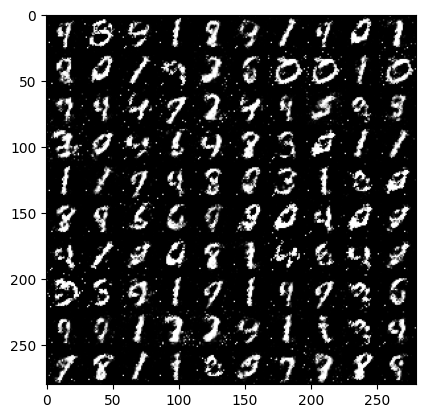

In [ ]:
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')


## Trying different optimizers

### Stochastic Gradient Descent (SGD)


In [ ]:
D = DiscriminatorV2().to(DEVICE)
G = GeneratorV2(n_noise).to(DEVICE)

D_opt = torch.optim.SGD(D.parameters(), lr=0.0002, momentum=0.9)
G_opt = torch.optim.SGD(G.parameters(), lr=0.0002, momentum=0.9)
#momentum helps accelerate SGD in the right direction and dampens oscillations.

D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

if not os.path.exists('samples_GANv2_SGD'):
    os.makedirs('samples_GANv2_SGD')

In [ ]:
train_gan(D, G, criterion, D_opt, G_opt, data_loader, MODEL_v1_NAME,'samples_GANv2_SGD')

Epoch: 0/15, Step: 0, D Loss: 1.3774418830871582, G Loss: 0.7218192219734192
Epoch: 1/15, Step: 500, D Loss: 0.6458432078361511, G Loss: 0.805514931678772
Epoch: 2/15, Step: 1000, D Loss: 0.6794991493225098, G Loss: 0.9474716186523438
Epoch: 3/15, Step: 1500, D Loss: 0.7687950134277344, G Loss: 0.9717062711715698
Epoch: 4/15, Step: 2000, D Loss: 0.8437868356704712, G Loss: 0.9913976788520813
Epoch: 5/15, Step: 2500, D Loss: 0.4919339418411255, G Loss: 1.6504325866699219
Epoch: 6/15, Step: 3000, D Loss: 0.2490347921848297, G Loss: 3.303821086883545
Epoch: 7/15, Step: 3500, D Loss: 0.259781152009964, G Loss: 2.9944939613342285
Epoch: 8/15, Step: 4000, D Loss: 0.31776565313339233, G Loss: 3.395141124725342
Epoch: 9/15, Step: 4500, D Loss: 0.1470503807067871, G Loss: 3.854975938796997
Epoch: 10/15, Step: 5000, D Loss: 0.1462613344192505, G Loss: 3.7896056175231934
Epoch: 11/15, Step: 5500, D Loss: 0.29999902844429016, G Loss: 3.5903124809265137
Epoch: 12/15, Step: 6000, D Loss: 0.184600293

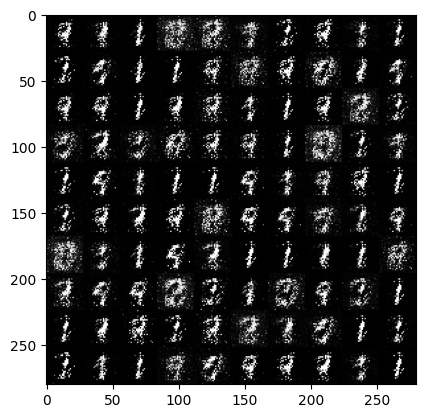

In [ ]:
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')


###NADAM
Combines the benefits of Nesterov accelerated gradient (NAG) with the adaptive learning rates of Adam

In [ ]:
D = DiscriminatorV2().to(DEVICE)
G = GeneratorV2(n_noise).to(DEVICE)

D_opt = torch.optim.NAdam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.NAdam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

if not os.path.exists('samples_GANv2_NADAM'):
    os.makedirs('samples_GANv2_NADAM')

In [ ]:
train_gan(D, G, criterion, D_opt, G_opt, data_loader, MODEL_v1_NAME,'samples_GANv2_NADAM')

Epoch: 0/15, Step: 0, D Loss: 1.4060347080230713, G Loss: 0.6970332264900208
Epoch: 1/15, Step: 500, D Loss: 1.3660398721694946, G Loss: 0.8450459241867065
Epoch: 2/15, Step: 1000, D Loss: 1.337871789932251, G Loss: 0.7344808578491211
Epoch: 3/15, Step: 1500, D Loss: 1.3306808471679688, G Loss: 0.9008757472038269
Epoch: 4/15, Step: 2000, D Loss: 1.2921088933944702, G Loss: 1.013657569885254
Epoch: 5/15, Step: 2500, D Loss: 1.3158283233642578, G Loss: 0.9303497076034546
Epoch: 6/15, Step: 3000, D Loss: 1.3212647438049316, G Loss: 0.7412705421447754
Epoch: 7/15, Step: 3500, D Loss: 1.3390140533447266, G Loss: 0.7878537178039551
Epoch: 8/15, Step: 4000, D Loss: 1.3150286674499512, G Loss: 0.8823593854904175
Epoch: 9/15, Step: 4500, D Loss: 1.2636234760284424, G Loss: 0.8688885569572449
Epoch: 10/15, Step: 5000, D Loss: 1.273177981376648, G Loss: 0.8449054956436157
Epoch: 11/15, Step: 5500, D Loss: 1.3051674365997314, G Loss: 0.9754410982131958
Epoch: 12/15, Step: 6000, D Loss: 1.295673727

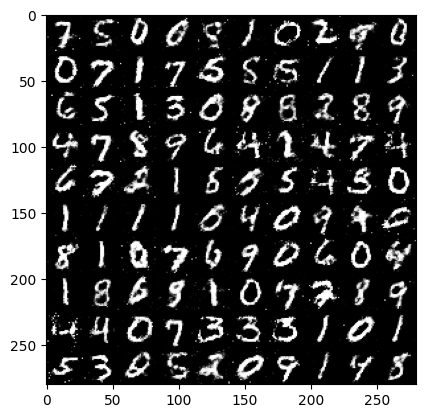

In [ ]:
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')


### RMSprop:
RMSprop is an optimizer that adjusts the learning rates by dividing them by an exponentially decaying average of squared gradients.

In [ ]:
D = DiscriminatorV2().to(DEVICE)
G = GeneratorV2(n_noise).to(DEVICE)


D_opt = torch.optim.RMSprop(D.parameters(), lr=0.0002, alpha = 0.9)
G_opt = torch.optim.RMSprop(G.parameters(), lr=0.0002, alpha = 0.9)
#alpha is a smoothing constant that helps with the calculation of the moving average of squared gradients.


D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

if not os.path.exists('samples_GANv2_RMS'):
    os.makedirs('samples_GANv2_RMS')

In [ ]:
train_gan(D, G, criterion, D_opt, G_opt, data_loader, MODEL_v1_NAME,'samples_GANv2_RMS')

Epoch: 0/15, Step: 0, D Loss: 1.3779082298278809, G Loss: 0.7186084389686584
Epoch: 1/15, Step: 500, D Loss: 1.349652886390686, G Loss: 0.8388714790344238
Epoch: 2/15, Step: 1000, D Loss: 1.3633530139923096, G Loss: 0.8985030651092529
Epoch: 3/15, Step: 1500, D Loss: 1.3501108884811401, G Loss: 0.8676875233650208
Epoch: 4/15, Step: 2000, D Loss: 1.3756048679351807, G Loss: 0.8563300371170044
Epoch: 5/15, Step: 2500, D Loss: 1.428555965423584, G Loss: 0.9959224462509155
Epoch: 6/15, Step: 3000, D Loss: 1.3361613750457764, G Loss: 0.7641531229019165
Epoch: 7/15, Step: 3500, D Loss: 1.3740184307098389, G Loss: 0.9519731998443604
Epoch: 8/15, Step: 4000, D Loss: 1.3403782844543457, G Loss: 0.747795581817627
Epoch: 9/15, Step: 4500, D Loss: 1.3550817966461182, G Loss: 0.8065381050109863
Epoch: 10/15, Step: 5000, D Loss: 1.3455272912979126, G Loss: 0.744797945022583
Epoch: 11/15, Step: 5500, D Loss: 1.3601832389831543, G Loss: 0.9406613111495972
Epoch: 12/15, Step: 6000, D Loss: 1.3821790218

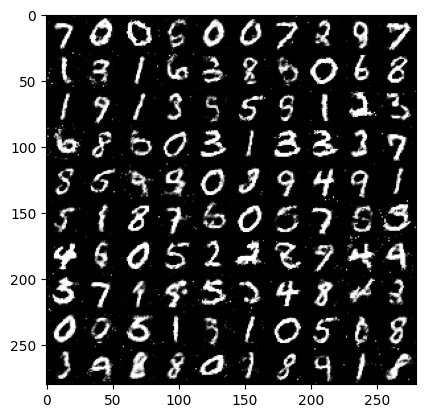

In [ ]:
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')


## More complex model and optimizers - conclusions



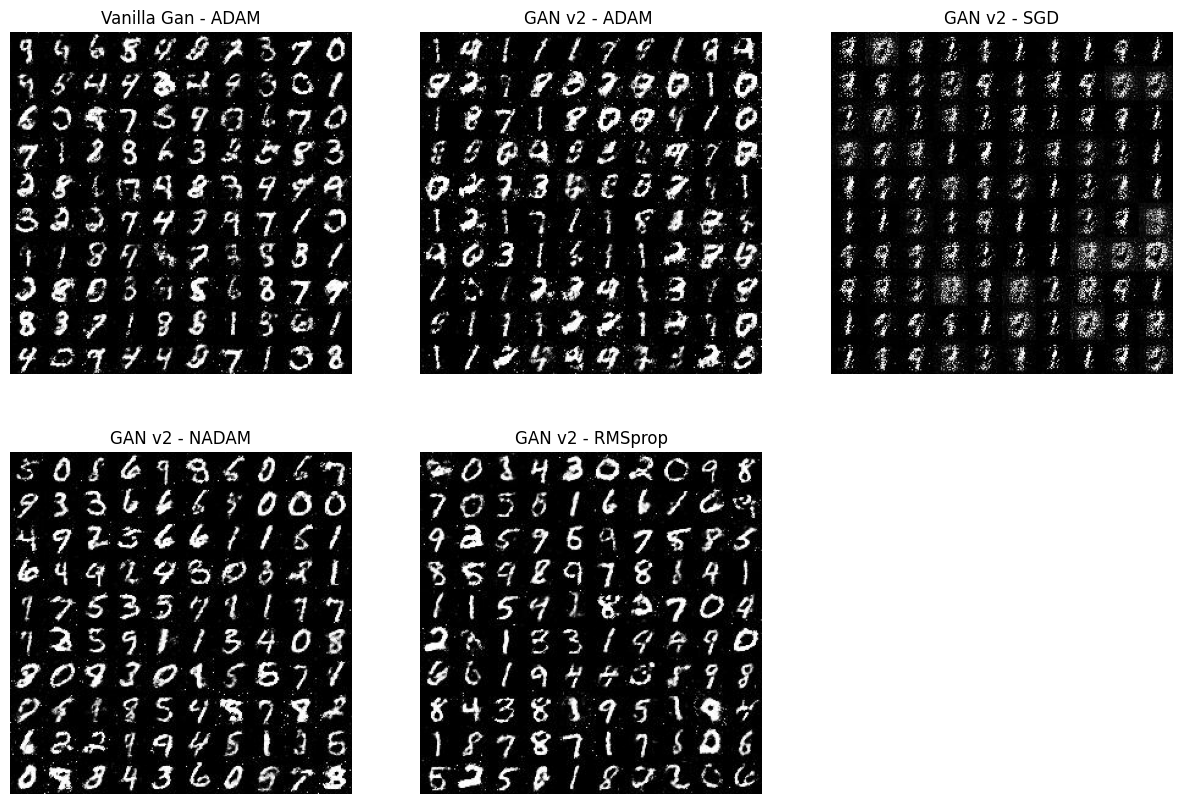

In [ ]:
# Image file paths
path1 = 'samples_GAN_VANILLA/vanilla-GAN_GAN_step7000.jpg'
path2 = 'samples_GANv2/vanilla-GAN_GAN_step7000.jpg'
path3 = 'samples_GANv2_SGD/vanilla-GAN_GAN_step7000.jpg'
path4 = 'samples_GANv2_NADAM/vanilla-GAN_GAN_step7000.jpg'
path5 = 'samples_GANv2_RMS/vanilla-GAN_GAN_step7000.jpg'

# Load and display images side by side
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Adjust figsize to scale the display size

axs[0,0].imshow(plt.imread(path1))
axs[0,0].set_title('Vanilla Gan - ADAM')
axs[0,0].axis('off')  # Turn off axis

axs[0,1].imshow(plt.imread(path2))
axs[0,1].set_title('GAN v2 - ADAM ')
axs[0,1].axis('off')  # Turn off axis

axs[0,2].imshow(plt.imread(path3))
axs[0,2].set_title('GAN v2 - SGD')
axs[0,2].axis('off')  # Turn off axis

axs[1,0].imshow(plt.imread(path4))
axs[1,0].set_title('GAN v2 - NADAM')
axs[1,0].axis('off')  # Turn off axis

axs[1,1].imshow(plt.imread(path5))
axs[1,1].set_title('GAN v2 - RMSprop')
axs[1,1].axis('off')  # Turn off axis

axs[1,2].axis('off')


plt.show()

Extending the network size didn't definitively improve the output quality. In fact, the smaller Vanilla GAN, which also uses ADAM, produced less grainy images with more recognizable digits. This could suggest that the larger network's design is possibly unoptimized, leading to overfitting or difficulty in training due to the increased complexity.

However, applying different optimization algorithms to the larger network revealed varying results, highlighting how crucial the right optimizer can be in managing larger and more complex models:


*   **SGD** - yielded disappointing results, with most outputs appearing as grainy stripes or just grains. This is likely due to SGD's inability to navigate the complex error landscape of a larger network effectively, possibly getting stuck in poor local minima or not adjusting learning rates adaptively.
*   **NADAM** - produced crisper images that were less grainy, making digits the easiest to identify. Nadam's effectiveness can be attributed to its incorporation of Nesterov momentum, which helps anticipate future gradients and adjust updates more effectively, leading to smoother and more stable training progress.
* **RMSprop** - also delivered decent results, though slightly grainier than NADAM. The shapes of the digits were the most accurate. This performance can be due to RMSprop's design to adapt learning rates based on recent gradient magnitudes, which helps it deal better with the noisy gradients of a GAN's discriminator, allowing for more precise updates that preserve useful characteristics of the digits.


When selecting an optimizer for GAN networks, it's best to opt for algorithms like ADAM and NADAM that adjust learning rates adaptively, so for now on - when exploring the latent spaces of the generator we'll use NADAM as the optimizer.

#GAN with one Convolutional Layer and Latent Space size variations

For this project, I decided to keep things simple instead of diving into a full Convolutional GAN setup, knowing we'll tackle that in our next lab session. My goal was to see what happens when you add just one convolutional layer to a GAN and how playing around with the latent space size affects the output quality and performance.

## - Latent space - 150

In [ ]:
n_noise = 150

D = DiscriminatorV3().to(DEVICE)
G = GeneratorV3(n_noise).to(DEVICE)

D_opt = torch.optim.NAdam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.NAdam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake


if not os.path.exists('samples_GANv3_150'):
    os.makedirs('samples_GANv3_150')

In [ ]:
train_gan(D, G, criterion, D_opt, G_opt, data_loader, MODEL_v1_NAME,'samples_GANv3_150',n_noise)

Epoch: 0/15, Step: 0, D Loss: 1.3878626823425293, G Loss: 0.6935504674911499
Epoch: 1/15, Step: 500, D Loss: 0.8867044448852539, G Loss: 1.0642496347427368
Epoch: 2/15, Step: 1000, D Loss: 0.7367635369300842, G Loss: 1.3512768745422363
Epoch: 3/15, Step: 1500, D Loss: 0.8647060394287109, G Loss: 2.0840957164764404
Epoch: 4/15, Step: 2000, D Loss: 0.7770727276802063, G Loss: 1.5373204946517944
Epoch: 5/15, Step: 2500, D Loss: 0.8322761654853821, G Loss: 2.3373332023620605
Epoch: 6/15, Step: 3000, D Loss: 0.5990082025527954, G Loss: 1.850525140762329
Epoch: 7/15, Step: 3500, D Loss: 0.6179355382919312, G Loss: 1.8884963989257812
Epoch: 8/15, Step: 4000, D Loss: 0.5624665021896362, G Loss: 2.488251209259033
Epoch: 9/15, Step: 4500, D Loss: 0.6472721099853516, G Loss: 1.7476122379302979
Epoch: 10/15, Step: 5000, D Loss: 0.6567910313606262, G Loss: 1.6475001573562622
Epoch: 11/15, Step: 5500, D Loss: 0.4643321633338928, G Loss: 2.061767339706421
Epoch: 12/15, Step: 6000, D Loss: 0.519932866

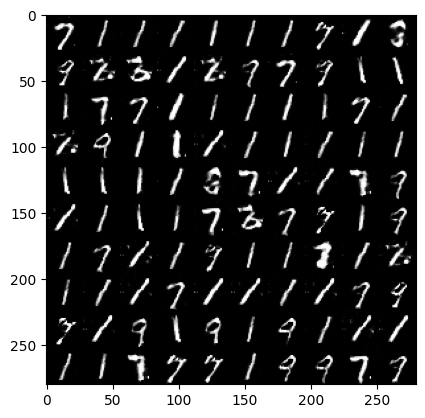

In [ ]:
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')


##Latent space - 200

In [ ]:
n_noise  = 200
D = DiscriminatorV3().to(DEVICE)
G = GeneratorV3(n_noise).to(DEVICE)

D_opt = torch.optim.NAdam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.NAdam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake


if not os.path.exists('samples_GANv3_200'):
    os.makedirs('samples_GANv3_200')

In [ ]:
train_gan(D, G, criterion, D_opt, G_opt, data_loader, MODEL_v1_NAME,'samples_GANv3_200',n_noise)

Epoch: 0/15, Step: 0, D Loss: 1.3843402862548828, G Loss: 0.6818993091583252
Epoch: 1/15, Step: 500, D Loss: 0.8980958461761475, G Loss: 1.4961587190628052
Epoch: 2/15, Step: 1000, D Loss: 0.7407259941101074, G Loss: 2.491892099380493
Epoch: 3/15, Step: 1500, D Loss: 0.5905522704124451, G Loss: 1.6932201385498047
Epoch: 4/15, Step: 2000, D Loss: 0.6862010955810547, G Loss: 1.7395737171173096
Epoch: 5/15, Step: 2500, D Loss: 0.6897226572036743, G Loss: 1.631035327911377
Epoch: 6/15, Step: 3000, D Loss: 0.699894905090332, G Loss: 2.9633216857910156
Epoch: 7/15, Step: 3500, D Loss: 0.45333993434906006, G Loss: 2.3309051990509033
Epoch: 8/15, Step: 4000, D Loss: 0.5918204188346863, G Loss: 2.131925582885742
Epoch: 9/15, Step: 4500, D Loss: 0.4528692066669464, G Loss: 2.2506401538848877
Epoch: 10/15, Step: 5000, D Loss: 0.5224592685699463, G Loss: 2.231029987335205
Epoch: 11/15, Step: 5500, D Loss: 0.46360790729522705, G Loss: 2.0985445976257324
Epoch: 12/15, Step: 6000, D Loss: 0.519605517

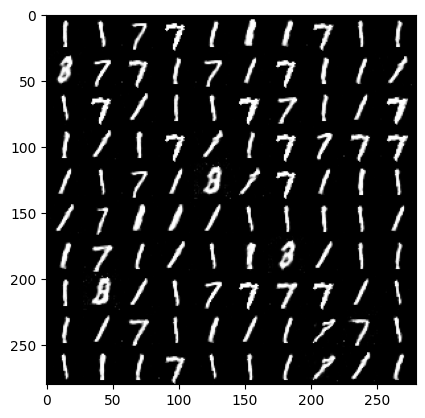

In [ ]:
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')


##Latent space - 300

In [ ]:
n_noise  = 300
D = DiscriminatorV3().to(DEVICE)
G = GeneratorV3(n_noise).to(DEVICE)

D_opt = torch.optim.NAdam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.NAdam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

if not os.path.exists('samples_GANv3_300'):
    os.makedirs('samples_GANv3_300')

In [ ]:
train_gan(D, G, criterion, D_opt, G_opt, data_loader, MODEL_v1_NAME,'samples_GANv3_300',n_noise)

Epoch: 0/15, Step: 0, D Loss: 1.3878097534179688, G Loss: 0.7279873490333557
Epoch: 1/15, Step: 500, D Loss: 1.1746795177459717, G Loss: 2.9700896739959717
Epoch: 2/15, Step: 1000, D Loss: 0.926384449005127, G Loss: 1.1508324146270752
Epoch: 3/15, Step: 1500, D Loss: 0.7603719234466553, G Loss: 2.1588029861450195
Epoch: 4/15, Step: 2000, D Loss: 0.6978349685668945, G Loss: 2.597262382507324
Epoch: 5/15, Step: 2500, D Loss: 0.4958871603012085, G Loss: 1.9397008419036865
Epoch: 6/15, Step: 3000, D Loss: 0.5497466325759888, G Loss: 2.155752658843994
Epoch: 7/15, Step: 3500, D Loss: 0.566686749458313, G Loss: 2.956089496612549
Epoch: 8/15, Step: 4000, D Loss: 0.5757063627243042, G Loss: 1.9683358669281006
Epoch: 9/15, Step: 4500, D Loss: 0.6883596181869507, G Loss: 1.968161702156067
Epoch: 10/15, Step: 5000, D Loss: 0.6124551892280579, G Loss: 2.208070755004883
Epoch: 11/15, Step: 5500, D Loss: 0.4065968096256256, G Loss: 2.147676944732666
Epoch: 12/15, Step: 6000, D Loss: 0.52525037527084

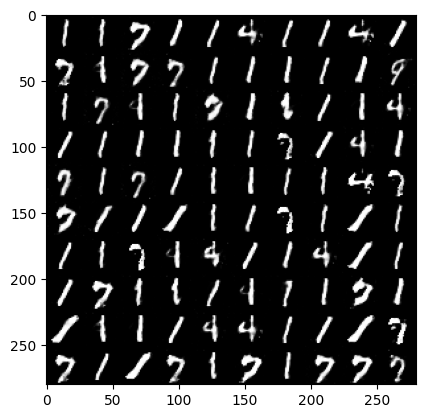

In [ ]:
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')


##Latent space - 75

In [ ]:
n_noise  = 75
D = DiscriminatorV3().to(DEVICE)
G = GeneratorV3(n_noise).to(DEVICE)

D_opt = torch.optim.NAdam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.NAdam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

if not os.path.exists('samples_GANv3_75'):
    os.makedirs('samples_GANv3_75')

In [ ]:
train_gan(D, G, criterion, D_opt, G_opt, data_loader, MODEL_v1_NAME,'samples_GANv3_75',n_noise)

Epoch: 0/15, Step: 0, D Loss: 1.386164665222168, G Loss: 0.701371431350708
Epoch: 1/15, Step: 500, D Loss: 1.0872862339019775, G Loss: 1.1686075925827026
Epoch: 2/15, Step: 1000, D Loss: 1.232422113418579, G Loss: 1.0968859195709229
Epoch: 3/15, Step: 1500, D Loss: 0.7585445642471313, G Loss: 1.6677846908569336
Epoch: 4/15, Step: 2000, D Loss: 0.5855880379676819, G Loss: 1.828643560409546
Epoch: 5/15, Step: 2500, D Loss: 0.586001992225647, G Loss: 3.1166646480560303
Epoch: 6/15, Step: 3000, D Loss: 0.8218706846237183, G Loss: 2.0431926250457764
Epoch: 7/15, Step: 3500, D Loss: 0.6408895254135132, G Loss: 2.437000274658203
Epoch: 8/15, Step: 4000, D Loss: 0.6821399927139282, G Loss: 2.2593836784362793
Epoch: 9/15, Step: 4500, D Loss: 0.5322800278663635, G Loss: 1.8245272636413574
Epoch: 10/15, Step: 5000, D Loss: 0.565975546836853, G Loss: 1.7563401460647583
Epoch: 11/15, Step: 5500, D Loss: 0.6253173351287842, G Loss: 3.1743032932281494
Epoch: 12/15, Step: 6000, D Loss: 0.4272388815879

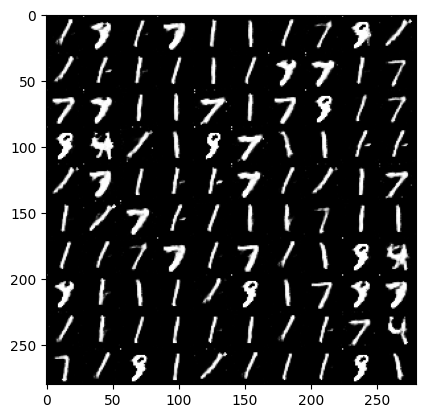

In [ ]:
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')


#GAN with convolution - conclusions:

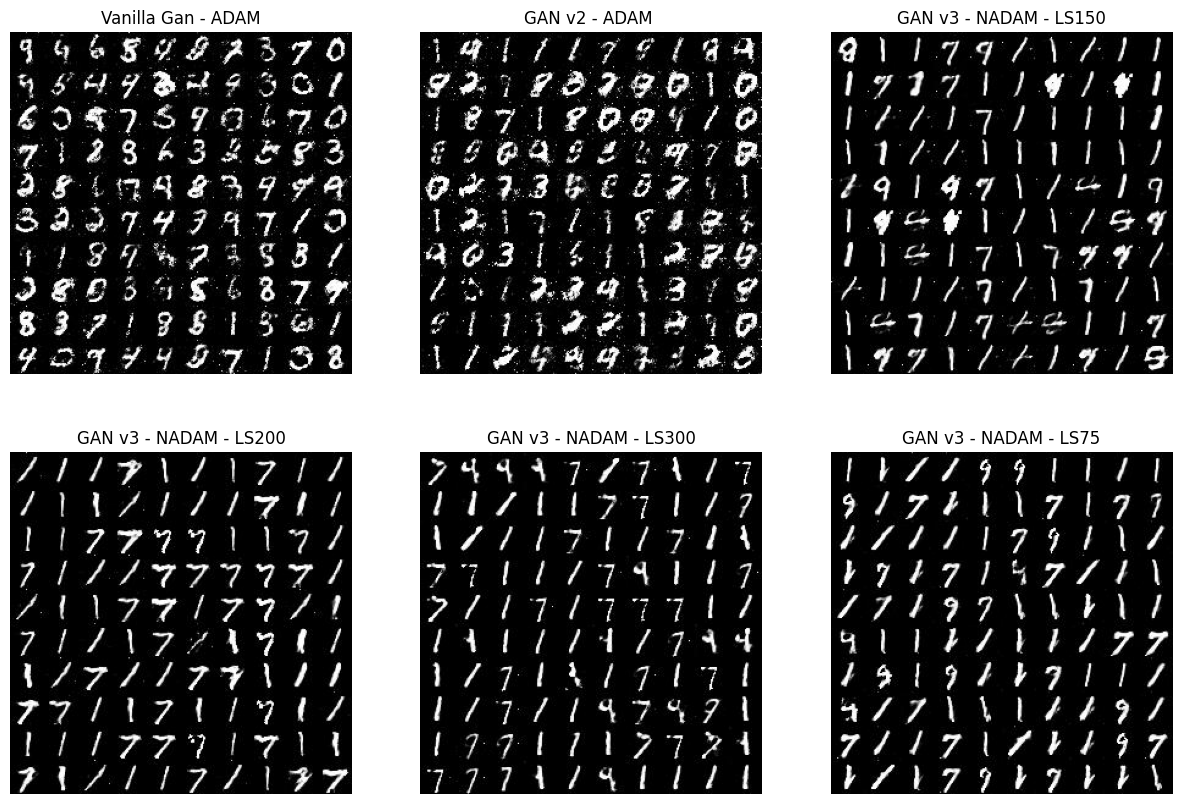

In [ ]:
# Image file paths
path1 = 'samples_GAN_VANILLA/vanilla-GAN_GAN_step7000.jpg'
path2 = 'samples_GANv2/vanilla-GAN_GAN_step7000.jpg'
path3 = 'samples_GANv3_150/vanilla-GAN_GAN_step7000.jpg'
path4 = 'samples_GANv3_200/vanilla-GAN_GAN_step7000.jpg'
path5 = 'samples_GANv3_300/vanilla-GAN_GAN_step7000.jpg'
path6 = 'samples_GANv3_75/vanilla-GAN_GAN_step7000.jpg'

# Load and display images side by side
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Adjust figsize to scale the display size

axs[0,0].imshow(plt.imread(path1))
axs[0,0].set_title('Vanilla Gan - ADAM')
axs[0,0].axis('off')  # Turn off axis

axs[0,1].imshow(plt.imread(path2))
axs[0,1].set_title('GAN v2 - ADAM ')
axs[0,1].axis('off')  # Turn off axis

axs[0,2].imshow(plt.imread(path3))
axs[0,2].set_title('GAN v3 - NADAM - LS150')
axs[0,2].axis('off')  # Turn off axis

axs[1,0].imshow(plt.imread(path4))
axs[1,0].set_title('GAN v3 - NADAM - LS200')
axs[1,0].axis('off')  # Turn off axis

axs[1,1].imshow(plt.imread(path5))
axs[1,1].set_title('GAN v3 - NADAM - LS300')
axs[1,1].axis('off')  # Turn off axis

axs[1,2].imshow(plt.imread(path6))
axs[1,2].set_title('GAN v3 - NADAM - LS75')
axs[1,2].axis('off')  # Turn off axis



plt.show()

Adding just one convolutional layer to the GAN resulted in a decrease in the diversity of generated results, with the model primarily producing images of specific digits. This suggests that a single convolutional layer might not be sufficient to capture the complexity needed for generating a wider variety of digits. Nonetheless, the output images were mostly free from graininess, indicating that the convolutional layer did enhance the image quality in terms of texture and shape. Further experimentation with varying latent space sizes revealed a notable dependency - larger latent spaces led to better-defined silhouettes or more varied digit generation.

#Summary

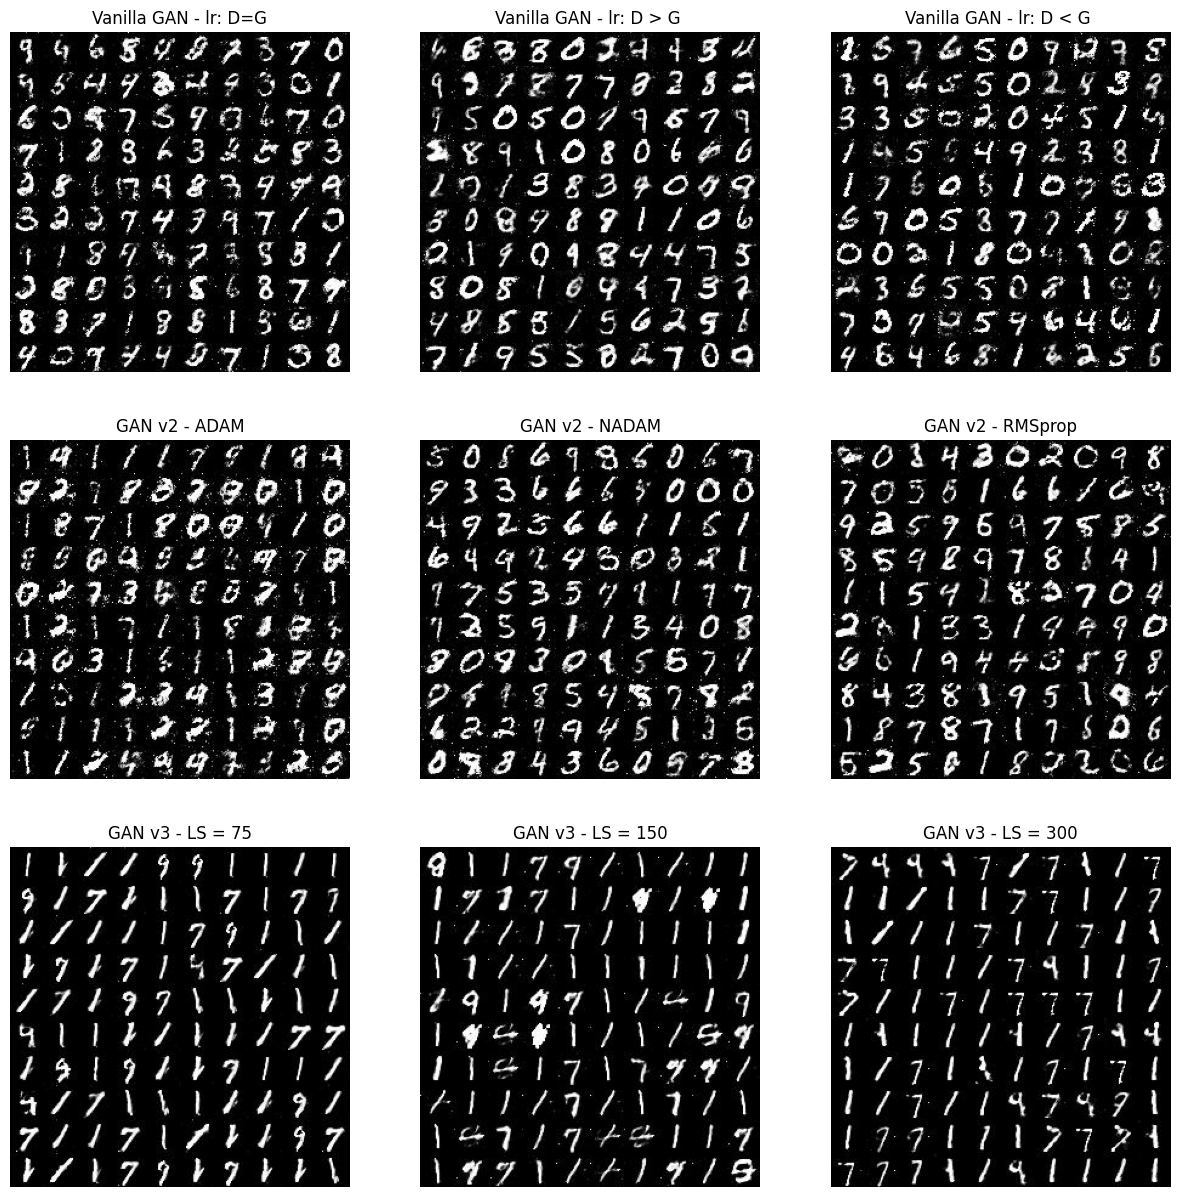

In [ ]:
# Image file paths
path1 = 'samples_GAN_VANILLA/vanilla-GAN_GAN_step7000.jpg'
path2 = 'samples_GAN_DISC/vanilla-GAN_GAN_step7000.jpg'
path3 = 'samples_GAN_GEN/vanilla-GAN_GAN_step7000.jpg'


path4 = 'samples_GANv2/vanilla-GAN_GAN_step7000.jpg'
path5 = 'samples_GANv2_NADAM/vanilla-GAN_GAN_step7000.jpg'
path6 = 'samples_GANv2_RMS/vanilla-GAN_GAN_step7000.jpg'

path7 = 'samples_GANv3_75/vanilla-GAN_GAN_step7000.jpg'
path8 = 'samples_GANv3_150/vanilla-GAN_GAN_step7000.jpg'
path9 = 'samples_GANv3_300/vanilla-GAN_GAN_step7000.jpg'
# Load and display images side by side
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Adjust figsize to scale the display size

axs[0,0].imshow(plt.imread(path1))
axs[0,0].set_title('Vanilla GAN - lr: D=G')
axs[0,0].axis('off')  # Turn off axis

axs[0,1].imshow(plt.imread(path2))
axs[0,1].set_title('Vanilla GAN - lr: D > G ')
axs[0,1].axis('off')  # Turn off axis

axs[0,2].imshow(plt.imread(path3))
axs[0,2].set_title('Vanilla GAN - lr: D < G ')
axs[0,2].axis('off')  # Turn off axis

axs[1,0].imshow(plt.imread(path4))
axs[1,0].set_title('GAN v2 - ADAM')
axs[1,0].axis('off')  # Turn off axis

axs[1,1].imshow(plt.imread(path5))
axs[1,1].set_title('GAN v2 - NADAM')
axs[1,1].axis('off')  # Turn off axis

axs[1,2].imshow(plt.imread(path6))
axs[1,2].set_title('GAN v2 - RMSprop')
axs[1,2].axis('off')  # Turn off axis


axs[2,0].imshow(plt.imread(path7))
axs[2,0].set_title('GAN v3 - LS = 75')
axs[2,0].axis('off')  # Turn off axis

axs[2,1].imshow(plt.imread(path8))
axs[2,1].set_title('GAN v3 - LS = 150')
axs[2,1].axis('off')  # Turn off axis

axs[2,2].imshow(plt.imread(path9))
axs[2,2].set_title('GAN v3 - LS = 300')
axs[2,2].axis('off')  # Turn off axis


plt.show()



*   **Learning Rate** - It influences network equilibrium in an unhelpful manner. The dual model system requires equal capabilities to effectively compete and outsmart each other.
*   **Model Volumne:**  -  Increasing the number of parameters and the volume of data generally enhances performance, but it's vital to employ a performant optimizer and carefully designed architectures. The model with one convolutional layer in both the Discriminator and Generator shows improved differentiation of data features, although a single layer is insufficient for adequately retaining features of this dataset.
*   **Optimizers** - Selecting an optimizer that complements the model architecture is crucial
*   **Latent space:** - Modifying the latent space size influenced the distribution sizes within it, affecting the likelihood of accurately predicting specific points. When the latent space was reduced to LS75, the resulting digits were more well-defined but showed less variation. Conversely, with a larger latent space size of LS300, there was an increase in digit variation, although the clarity of these digits was somewhat compromised.